<a href="https://colab.research.google.com/github/MoneyMS/Master-Thesis/blob/main/Master%20Thesis%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [32]:
#This code fetches political stability and control of corruption data from the World Bank API for the chosen 39 emerging countries from 2019 to 2023, merges them into a single dataset, and saves the result as a CSV file.
# List of ISO-3 codes for our 39 countries
countries = [
    "ZAF", "ARG", "AZE", "BGD", "BRA", "CHL", "CHN", "COL", "CIV",
    "EGY", "ECU", "ETH", "GEO", "GHA", "IND", "IDN", "JOR", "KAZ",
    "KEN", "MYS", "MAR", "MEX", "NGA", "PAN", "PAK", "PER", "PHL",
    "POL", "DOM", "ROU", "SEN", "SRB", "LKA", "THA", "TUN", "TUR",
    "UKR", "URY", "VNM"
]

def fetch_indicator_data(indicator_code, indicator_name):
    country_str = ";".join(countries)
    url = f"https://api.worldbank.org/v2/country/{country_str}/indicator/{indicator_code}"
    params = {
        "format": "json",
        "date": "2019:2023",
        "per_page": 2000
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data_json = response.json()
        data = pd.json_normalize(data_json[1])
        df = data[["country.id", "country.value", "date", "value"]].dropna()
        df.columns = ["country_code", "country", "year", indicator_name]
        df["year"] = df["year"].astype(int)
        return df
    else:
        print(f"Failed to fetch data for {indicator_code}")
        return pd.DataFrame()

df_pv = fetch_indicator_data("PV.EST", "political_stability")
df_cc = fetch_indicator_data("CC.EST", "control_of_corruption")

df_combined = pd.merge(df_pv, df_cc, on=["country", "year"], how="outer")

df_combined = df_combined.sort_values(["country", "year"])
print(df_combined.head(10))

df_combined.to_csv("wgi_political_corruption_2019_2023.csv", index=False)

#This was used to download as a csv the data collected via the code above
"""
from google.colab import files
df_combined.to_csv("wgi_political_corruption_2019_2023.csv", index=False)
files.download("wgi_political_corruption_2019_2023.csv")
"""

  country_code_x     country  year  political_stability country_code_y  \
0             AR   Argentina  2019            -0.097823             AR   
1             AR   Argentina  2020            -0.071997             AR   
2             AR   Argentina  2021             0.000530             AR   
3             AR   Argentina  2022            -0.098594             AR   
4             AR   Argentina  2023            -0.127518             AR   
5             AZ  Azerbaijan  2019            -0.693411             AZ   
6             AZ  Azerbaijan  2020            -0.852254             AZ   
7             AZ  Azerbaijan  2021            -0.837824             AZ   
8             AZ  Azerbaijan  2022            -0.922807             AZ   
9             AZ  Azerbaijan  2023            -0.730754             AZ   

   control_of_corruption  
0              -0.107116  
1              -0.163570  
2              -0.422597  
3              -0.447222  
4              -0.360884  
5              -0.84968

'\nfrom google.colab import files\ndf_combined.to_csv("wgi_political_corruption_2019_2023.csv", index=False)\nfiles.download("wgi_political_corruption_2019_2023.csv")\n'

In [33]:
# Load dataset from GitHub
url = "https://raw.githubusercontent.com/MoneyMS/Master-Thesis/main/Final_Data_Formatted_Panel.xlsx"
data = pd.read_excel(url)

# Log-transform GDP
data['Log_GDP'] = np.log(data['GDP (constant 2015 US$)'])

# Define dependent and explanatory variables
dependent_var = 'Foreign direct investment, net inflows (% of GDP)'
explanatory_vars = [
    'GDP growth (annual %)',
    'Log_GDP',
    'Inflation, consumer prices (annual %)',
    'Trade (% of GDP)',
    'Political stability',
    'Control of corruption',
    'Individuals using the Internet (% of population)'
]

# Clean dataset
dataset = data[[dependent_var] + explanatory_vars].dropna()
X = sm.add_constant(dataset[explanatory_vars])
y = dataset[dependent_var]

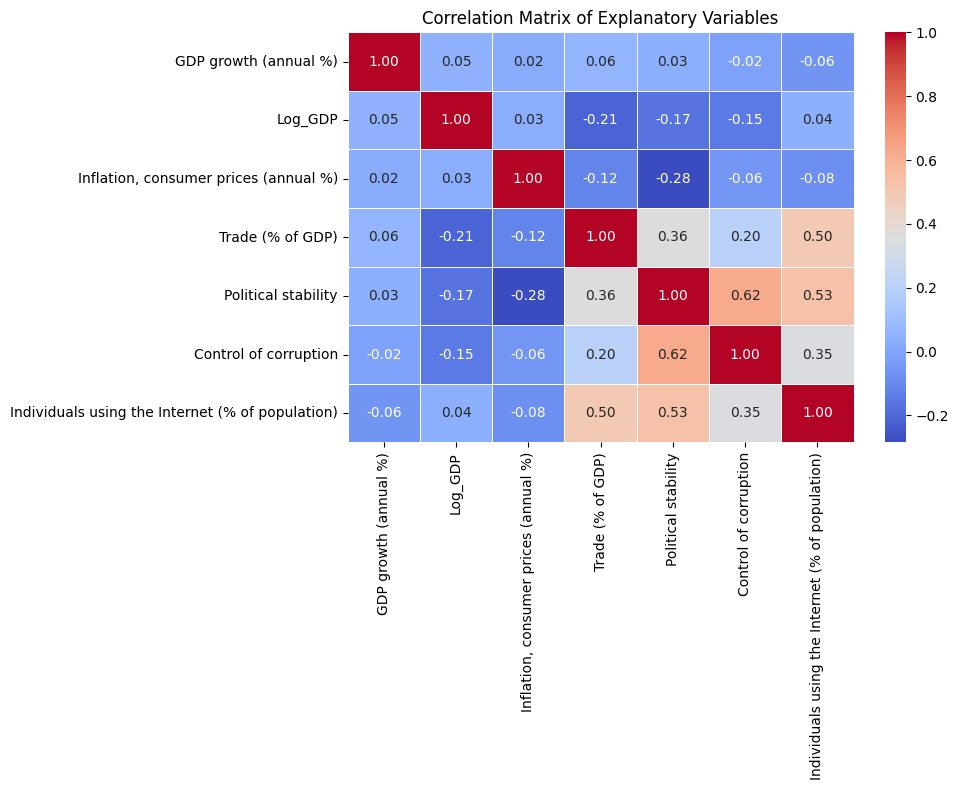

In [34]:
#Correlation matrix heatmap
corr_data = data[explanatory_vars].dropna()
corr_matrix = corr_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Explanatory Variables")
plt.tight_layout()
plt.show()

In [35]:
#Variance Inflation Factor (VIF) analysis
vif_data = data[explanatory_vars].dropna()
X_vif = sm.add_constant(vif_data)
vif_df = pd.DataFrame()
vif_df["Variable"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_df.sort_values(by="VIF", ascending=False))

                                           Variable         VIF
0                                             const  399.115083
5                               Political stability    2.316780
7  Individuals using the Internet (% of population)    1.793119
6                             Control of corruption    1.684479
4                                  Trade (% of GDP)    1.469025
2                                           Log_GDP    1.138918
3             Inflation, consumer prices (annual %)    1.131609
1                             GDP growth (annual %)    1.033279


In [36]:
#Compute the OLS regression model
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

                                            OLS Regression Results                                           
Dep. Variable:     Foreign direct investment, net inflows (% of GDP)   R-squared:                       0.267
Model:                                                           OLS   Adj. R-squared:                  0.237
Method:                                                Least Squares   F-statistic:                     8.856
Date:                                               Mon, 16 Jun 2025   Prob (F-statistic):           2.81e-09
Time:                                                       18:05:06   Log-Likelihood:                -399.80
No. Observations:                                                178   AIC:                             815.6
Df Residuals:                                                    170   BIC:                             841.0
Df Model:                                                          7                                         
Covariance

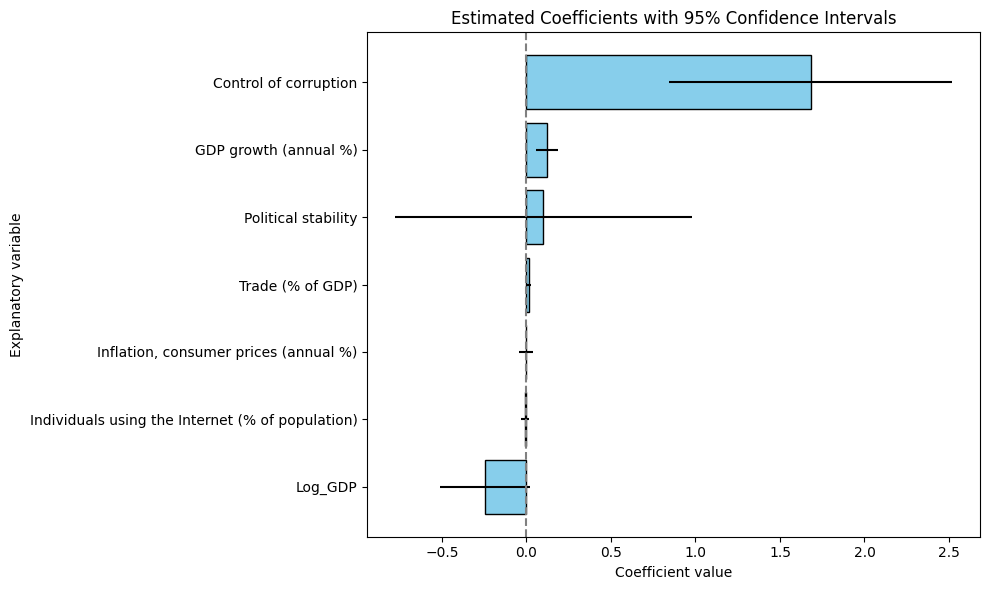

In [37]:
#Plot the previous regressions as an horizonta bar chart
coeffs = ols_model.conf_int()
coeffs.columns = ['CI_lower', 'CI_upper']
coeffs['Coefficient'] = ols_model.params
coeffs['Error'] = (coeffs['CI_upper'] - coeffs['CI_lower']) / 2
coeffs = coeffs.reset_index().rename(columns={'index': 'Variable'})
coeffs = coeffs[coeffs['Variable'] != 'const'].sort_values(by='Coefficient')

plt.figure(figsize=(10, 6))
plt.barh(
    y=coeffs['Variable'],
    width=coeffs['Coefficient'],
    xerr=coeffs['Error'],
    color='skyblue',
    edgecolor='black'
)
plt.axvline(x=0, color='gray', linestyle='--')
plt.title("Estimated Coefficients with 95% Confidence Intervals")
plt.xlabel("Coefficient value")
plt.ylabel("Explanatory variable")
plt.tight_layout()
plt.show()